 Cell 1: Download the dataset from Google Drive and extract (ZIP or TAR.GZ)


In [3]:


import shutil
from pathlib import Path
import gdown
import zipfile
import tarfile

 #Create a directory
data_dir = Path("chest_xray_data")
data_dir.mkdir(exist_ok=True)

# Direct‐download URL
gdrive_url = "https://drive.google.com/uc?id=1FraipuMFtH6blSVvCxCDhSROd7KQKq7z"
output_path = data_dir / "downloaded_data"

# Download
gdown.download(gdrive_url, str(output_path), quiet=False)

# Extract depending on archive type
if zipfile.is_zipfile(output_path):
    with zipfile.ZipFile(output_path, "r") as zf:
        zf.extractall(data_dir)
elif tarfile.is_tarfile(output_path):
    with tarfile.open(output_path, "r:*") as tf:
        tf.extractall(data_dir)
else:
    shutil.unpack_archive(str(output_path), extract_dir=str(data_dir))


Downloading...
From (original): https://drive.google.com/uc?id=1FraipuMFtH6blSVvCxCDhSROd7KQKq7z
From (redirected): https://drive.google.com/uc?id=1FraipuMFtH6blSVvCxCDhSROd7KQKq7z&confirm=t&uuid=984f0758-74ff-4f20-9391-328ede5dc1e9
To: /content/chest_xray_data/downloaded_data
100%|██████████| 836M/836M [00:08<00:00, 94.8MB/s]


Cell 2 :  Load the dataset (verify that images & masks are present)

In [4]:


from pathlib import Path

base_dir = Path("chest_xray_data")

image_dirs = list(base_dir.rglob("CXR_png_resized"))
mask_dirs  = list(base_dir.rglob("masks_resized"))

assert len(image_dirs) == 1 and len(mask_dirs) == 1, "Expected exactly one images and one masks folder"
images_folder = image_dirs[0]
masks_folder  = mask_dirs[0]

print("Images folder:", images_folder)
print("Masks folder: ", masks_folder)

# Count how many PNGs are inside each
print(f"  • # of image files: {len(list(images_folder.glob('*.png')))}")
print(f"  • # of mask  files: {len(list(masks_folder.glob('*.png')))}")


Images folder: chest_xray_data/Lung Segmentation/CXR_png_resized
Masks folder:  chest_xray_data/Lung Segmentation/masks_resized
  • # of image files: 800
  • # of mask  files: 704


Cell 3: “Load the dataset and visualize the X-ray images along with their corresponding segmentation masks.”

Found 566 valid image/mask pairs.


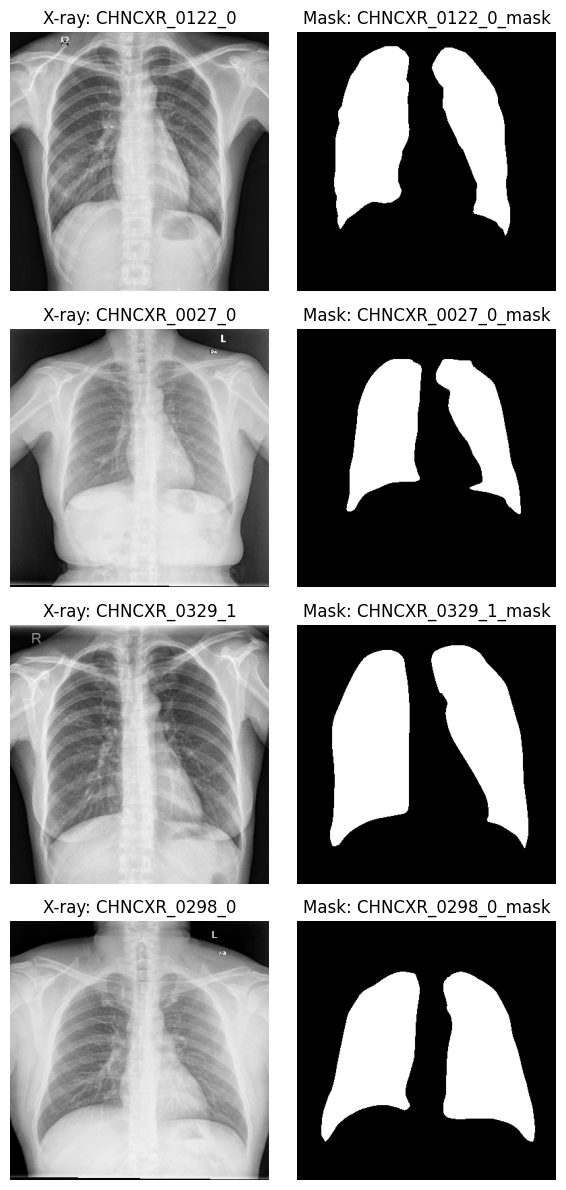

In [5]:


import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image

#  Build a list
all_image_paths = sorted(images_folder.glob("*.png"))
valid_stems = []
for img_path in all_image_paths:
    stem = img_path.stem  # CHNCXR_0001_0
    if (masks_folder / f"{stem}_mask.png").exists():
        valid_stems.append(stem)

print(f"Found {len(valid_stems)} valid image/mask pairs.")

# Sample 4 random stems
random.seed(42)
samples = random.sample(valid_stems, k=4)

# Plot image and mask
fig, axes = plt.subplots(len(samples), 2, figsize=(6, 12))
for i, stem in enumerate(samples):
    img = Image.open(images_folder / f"{stem}.png").convert("L")
    msk = Image.open(masks_folder  / f"{stem}_mask.png").convert("L")
    # Binarize mask for display: threshold at 128 → 255
    msk = msk.point(lambda p: 0 if p < 128 else 255)

    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title(f"X-ray: {stem}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(msk, cmap="gray")
    axes[i, 1].set_title(f"Mask: {stem}_mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


Normalize and resize the images to a consistent shape, and split the data into training and validation sets.
Use data augmentation techniques to improve generalization.

In [7]:


import random
import numpy as np
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode

# Build the list
all_image_paths = sorted(images_folder.glob("*.png"))
valid_stems = []
for img_path in all_image_paths:
    stem = img_path.stem
    if (masks_folder / f"{stem}_mask.png").exists():
        valid_stems.append(stem)

#  Shuffle and split 80/20
random.shuffle(valid_stems)
split_idx   = int(0.8 * len(valid_stems))
train_list  = valid_stems[:split_idx]
val_list    = valid_stems[split_idx:]

print(f" → {len(train_list)} training samples, {len(val_list)} validation samples")

# JointTransform: resize to (256,256), ugment during traininga
class JointTransform:
    def __init__(self, resize=(256, 256), augment=False):
        self.resize  = resize
        self.augment = augment
        # Only normalize image channel; mask stays binary {0,1}
        self.img_to_tensor = T.ToTensor()
        self.img_norm      = T.Normalize(mean=[0.5], std=[0.5])

    def __call__(self, img: Image.Image, msk: Image.Image):
        #  Resize
        img = TF.resize(img, self.resize, interpolation=InterpolationMode.BILINEAR)
        msk = TF.resize(msk, self.resize, interpolation=InterpolationMode.NEAREST)

        #  Optional flip + rotation
        if self.augment and random.random() < 0.5:
            img = TF.hflip(img)
            msk = TF.hflip(msk)
        if self.augment:
            angle = random.uniform(-15, 15)
            img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            msk = TF.rotate(msk, angle, interpolation=InterpolationMode.NEAREST)

        # Binarize mask: any pixel <128 → 0; else → 1
        msk = msk.point(lambda p: 0 if p < 128 else 1)

        # Convert image to tensor and normalize
        img_tensor = self.img_to_tensor(img)     # shape (1, H, W), values in [0,1]
        img_tensor = self.img_norm(img_tensor)   # now roughly in [-1,+1]

        # Convert mask to numpy to FloatTensor (shape (1,H,W))
        mask_np     = np.array(msk, dtype=np.uint8)          # (H, W), {0,1}
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).float()

        return img_tensor, mask_tensor

# Custom Dataset class
class ChestXraySegmentation(Dataset):
    def __init__(self, images_dir, masks_dir, name_list, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir  = Path(masks_dir)
        self.names      = name_list
        self.transform  = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        stem     = self.names[idx]
        img_path = self.images_dir / f"{stem}.png"
        msk_path = self.masks_dir  / f"{stem}_mask.png"

        # Open as grayscale
        img = Image.open(img_path).convert("L")
        msk = Image.open(msk_path).convert("L")

        if self.transform:
            img, msk = self.transform(img, msk)

        return img, msk

# Build train/val datasets & DataLoaders
train_ds = ChestXraySegmentation(
    images_folder, masks_folder, train_list,
    transform=JointTransform(resize=(256,256), augment=True)
)
val_ds = ChestXraySegmentation(
    images_folder, masks_folder, val_list,
    transform=JointTransform(resize=(256,256), augment=False)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0)

print(
      f"{len(train_loader)} train batches, {len(val_loader)} val batches")


 → 452 training samples, 114 validation samples
57 train batches, 15 val batches


Implement a U-Net architecture

In [8]:


import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """Two 3×3 conv → BN → ReLU, stacked twice"""
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_filters=32):
        super(UNet, self).__init__()
        f = base_filters

        # Encoder
        self.down1 = DoubleConv(in_channels, f)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f,          2*f)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(2*f,        4*f)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(4*f,        8*f)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(8*f,   16*f)

        # Decoder
        self.up4 = nn.ConvTranspose2d(16*f, 8*f, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(16*f,      8*f)
        self.up3 = nn.ConvTranspose2d(8*f,  4*f, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(8*f,       4*f)
        self.up2 = nn.ConvTranspose2d(4*f,  2*f, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(4*f,       2*f)
        self.up1 = nn.ConvTranspose2d(2*f,  f,   kernel_size=2, stride=2)
        self.conv1 = DoubleConv(2*f,       f)

        # Final 1×1 conv
        self.final_conv = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder + skip connections
        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        u3 = torch.cat([u3, d3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(u1)

        out = self.final_conv(c1)  # logits, shape (B,1,256,256)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, base_filters=32).to(device)
print(model)


UNet(
  (down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

pretraining setup

In [10]:


import torch.optim as optim
import torch.nn as nn

#  Binary segmentation → use BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer (lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler: reduce LR by 50% if val loss plateaus for 3 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.5
)

print(" Loss, optimizer, scheduler ready.")


 Loss, optimizer, scheduler ready.


Normalize and resize (implicit, because data loader uses transforms)

Use data augmentation (training loader had augment=True)

Prepares for Visualize predicted masks (generating predictions)

In [11]:


import torch
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(loader, desc="  Training", leave=False):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)             # raw logits
        loss    = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="  Validating", leave=False):
            images = images.to(device)
            masks  = masks.to(device)
            outputs = model(images)
            loss    = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

# Training setup
num_epochs      = 20
best_val_loss   = float("inf")
checkpoint_path = "best_unet_model.pth"

# Main training loop
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = validate_one_epoch(model, val_loader, criterion, device)

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")

    # Step scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)


print(f"Best validation loss: {best_val_loss:.4f}")


Epoch 1/20


  Train Loss: 0.3581
  Val   Loss: 0.2673
Epoch 2/20


  Train Loss: 0.2282
  Val   Loss: 0.2184
Epoch 3/20


  Train Loss: 0.2003
  Val   Loss: 0.1950
Epoch 4/20


  Train Loss: 0.1836
  Val   Loss: 0.1839
Epoch 5/20


  Train Loss: 0.1696
  Val   Loss: 0.1634
Epoch 6/20


  Train Loss: 0.1572
  Val   Loss: 0.1565
Epoch 7/20


  Train Loss: 0.1461
  Val   Loss: 0.1461
Epoch 8/20


  Train Loss: 0.1392
  Val   Loss: 0.1449
Epoch 9/20


  Train Loss: 0.1299
  Val   Loss: 0.1374
Epoch 10/20


  Train Loss: 0.1245
  Val   Loss: 0.1270
Epoch 11/20


  Train Loss: 0.1169
  Val   Loss: 0.1218
Epoch 12/20


  Train Loss: 0.1112
  Val   Loss: 0.1183
Epoch 13/20


  Train Loss: 0.1077
  Val   Loss: 0.1099
Epoch 14/20


  Train Loss: 0.1059
  Val   Loss: 0.1122
Epoch 15/20


  Train Loss: 0.0992
  Val   Loss: 0.1068
Epoch 16/20


  Train Loss: 0.0960
  Val   Loss: 0.1045
Epoch 17/20


  Train Loss: 0.0918
  Val   Loss: 0.0978
Epoch 18/20


  Train Loss: 0.0878
  Val   Loss: 0.0944
Epoch 19/20


  Train Loss: 0.0856
  Val   Loss: 0.0971
Epoch 20/20


  Train Loss: 0.0835
  Val   Loss: 0.0914
Best validation loss: 0.0914


Visualize the segmentation masks predicted by the model on the validation set

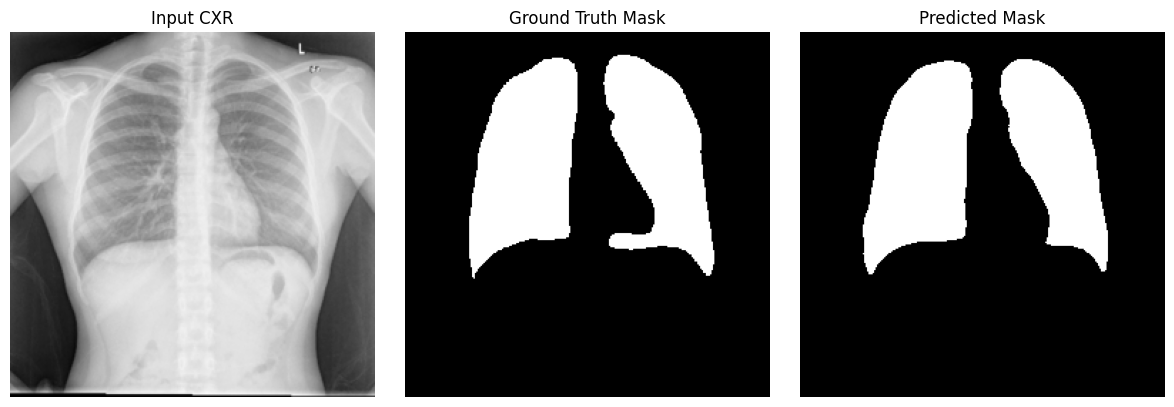

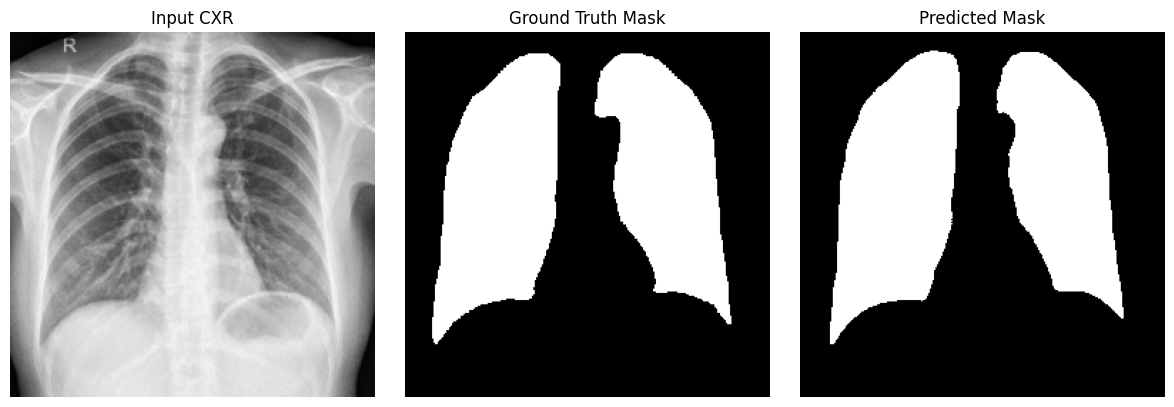

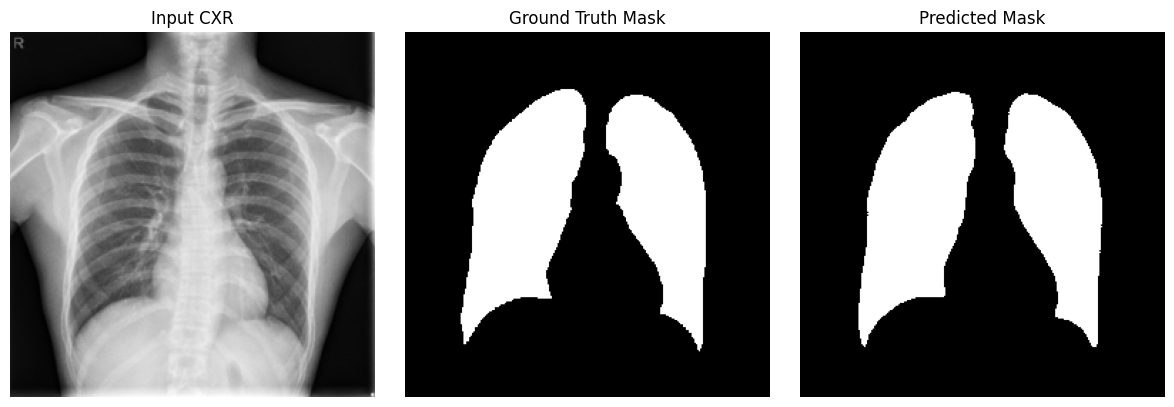

In [12]:


import torch
import matplotlib.pyplot as plt
import numpy as np

# Load best checkpoint
model.load_state_dict(torch.load("best_unet_model.pth", map_location=device))
model.eval()
model.to(device)

def plot_sample(img_tensor, true_mask, pred_logits):
    # Denormalize image
    img = img_tensor.cpu().numpy().squeeze()
    img = (img * 0.5) + 0.5

    true_m = true_mask.cpu().numpy().squeeze()

    prob = torch.sigmoid(pred_logits).cpu().detach().numpy().squeeze()
    pred_m = (prob > 0.5).astype(np.float32)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Input CXR")
    axs[0].axis("off")

    axs[1].imshow(true_m, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_m, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# Display 3 samples from validation loader
num_to_show = 3
shown = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks  = masks.to(device)
        outputs = model(images)  # raw logits
        for i in range(images.size(0)):
            if shown >= num_to_show:
                break
            plot_sample(images[i], masks[i], outputs[i])
            shown += 1
        if shown >= num_to_show:
            break
